In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.linear_model import LinearRegression

import os

if 'AALTO_JUPYTERHUB' in os.environ:
    # using jupyter shareddata directory
    DATA = '/coursedata/Final_project/'
else:
    DATA = '../../data/Final_project/'

## Data Preprocessing
Just some filtering of the data and removing unmeaningful data, and duplicates.

**calls dataset** column names:
* timestamp
* calling user
* call recipient
* duration (-1 means a missed call)

In [2]:
# load call data
calls = pd.read_csv("Files/calls.csv")

# remove missed calls and calls with duration = 0
calls = calls[(calls["duration"] != -1)& (calls["duration"] >= 0)] 

**sms dataset** column names:
* timestamp
* sender
* recipient

In [3]:
# load sms data
sms = pd.read_csv("Files/sms.csv")

# remove duplciates
sms = sms.drop_duplicates()

**BT symmetric dataset** column names:
* timestamp
* user A 
* user B 
* received signal strength

Notes:
Empty scans are marked with user B = -1 and RSSI = 0
Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID.

In [4]:
# load bluetooth data
bt = pd.read_csv("Files/bt_symmetric.csv")

# rename some columns
bt = bt.rename(columns={"# timestamp": "timestamp"})

# filter dataset
# remove empty scans with B = -1 and RSSI = 0
bt = bt[~((bt["user_b"] == -1) & (bt["rssi"] == 0))]

# remove devices outside experiment
bt = bt[(bt["user_b"] != -2)]

# keep only participant-participant interactions
bt = bt[(bt["user_a"] >= 0) & (bt["user_b"] >= 0)]

# remove any rssi = 0 which are either invalid or empty
bt = bt[bt["rssi"] != 0] 

**FB friends** column names:
* user A
* user B

Edge lists of all declared facebook friendships which were formed before the end of the observation and not dissolved until after the end of the observation.


In [5]:
# load facebook frienships
fb = pd.read_csv("Files/fb_friends.csv")

 # change the name of the user_a column
fb = fb.rename(columns={"# user_a": "user_a"})

**Gender** column names:
* user
* female

Gender label (0 = male, 1 = female)

In [45]:
# load genders
genders = pd.read_csv("Files/genders.csv")

# change the name of the user column
genders = genders.rename(columns={"# user": "user"})

# convert to dictionary {node_id: gender}
genders["female"].value_counts()

num_males = (genders["female"] == 0).sum()
num_females = (genders["female"] == 1).sum()

print("Number of males:", num_males)
print("Number of females:", num_females)

Number of males: 614
Number of females: 173


## Feature Engineering
First, I'll build edge lists. As of now, I only have raw interactions, not yet a network:
A graph of people (nodes) and their relationships (edges). This can be done using aggregation into edge lists. For each pair of users, we count how many times they interacted. And we do this sepparately for bluetooth, sms, and calls. Once we have these, we can construct a network of nodes (students), edges (connections between students), and weights (interaction stregth).

In [7]:
# undirected so that for example (120, 350) and (350, 120) are treated as one relation, not two 
bt["u_min"] = bt[["user_a", "user_b"]].min(axis=1)
bt["u_max"] = bt[["user_a", "user_b"]].max(axis=1)

prox_edges = (bt.groupby(["u_min", "u_max"]).size().reset_index(name="weight")) # group by each pair and count how many times they were in proximity

In [8]:
# do the same for sms
sms["u_min"] = sms[["sender", "recipient"]].min(axis=1)
sms["u_max"] = sms[["sender", "recipient"]].max(axis=1)

sms_edges = (sms.groupby(["u_min", "u_max"]).size().reset_index(name="weight"))

In [9]:
# same for calls
calls["u_min"] = calls[["caller", "callee"]].min(axis=1)
calls["u_max"] = calls[["caller", "callee"]].max(axis=1)

call_edges = (calls.groupby(["u_min", "u_max"]).size().reset_index(name="weight"))

In [10]:
# facebook friends are already undirected and don't need weights
fb_edges = fb[["user_a", "user_b"]].drop_duplicates()

Once aggregated, I can actually construct graphs in NetworkX

In [11]:
# Constructing the nx graphs
G_prox = nx.Graph()
G_sms = nx.Graph()
G_calls = nx.Graph()
G_fb = nx.Graph()

# for the weighted networks we need (node1, node2, weight) tuples, so we build them
G_prox.add_weighted_edges_from(prox_edges.to_numpy())
G_sms.add_weighted_edges_from(sms_edges.to_numpy())
G_calls.add_weighted_edges_from(call_edges.to_numpy())
G_fb.add_edges_from(fb_edges.to_numpy()) # fb graph is unweighted

In [12]:
# do some sanity checks
print("Proximity (BT) network:", G_prox.number_of_nodes(), "nodes,", G_prox.number_of_edges(), "edges")
print("SMS network:", G_sms.number_of_nodes(), "nodes,", G_sms.number_of_edges(), "edges")
print("Calls network:", G_calls.number_of_nodes(), "nodes,", G_calls.number_of_edges(), "edges")
print("Facebook network:", G_fb.number_of_nodes(), "nodes,", G_fb.number_of_edges(), "edges")

Proximity (BT) network: 692 nodes, 79530 edges
SMS network: 568 nodes, 697 edges
Calls network: 525 nodes, 605 edges
Facebook network: 800 nodes, 6429 edges


Everything seems okay, so now I will start doind the actual analyses.
## Basic Methods

In [13]:
# node counts
print("Nodes (Proximity):", G_prox.number_of_nodes())
print("Nodes (SMS):", G_sms.number_of_nodes())
print("Nodes (Calls):", G_calls.number_of_nodes())
print("Nodes (Facebook):", G_fb.number_of_nodes())
print("\n")

# edge counts
print("Edges (Proximity):", G_prox.number_of_edges())
print("Edges (SMS):", G_sms.number_of_edges())
print("Edges (Calls):", G_calls.number_of_edges())
print("Edges (Facebook):", G_fb.number_of_edges())
print("\n")

# netwrok densities
print("Density (Proximity):", nx.density(G_prox))
print("Density (SMS):", nx.density(G_sms))
print("Density (Calls):", nx.density(G_calls))
print("Density (Facebook):", nx.density(G_fb))


Nodes (Proximity): 692
Nodes (SMS): 568
Nodes (Calls): 525
Nodes (Facebook): 800


Edges (Proximity): 79530
Edges (SMS): 697
Edges (Calls): 605
Edges (Facebook): 6429


Density (Proximity): 0.33264181089649747
Density (SMS): 0.004328439774449164
Density (Calls): 0.004398400581606688
Density (Facebook): 0.020115769712140175


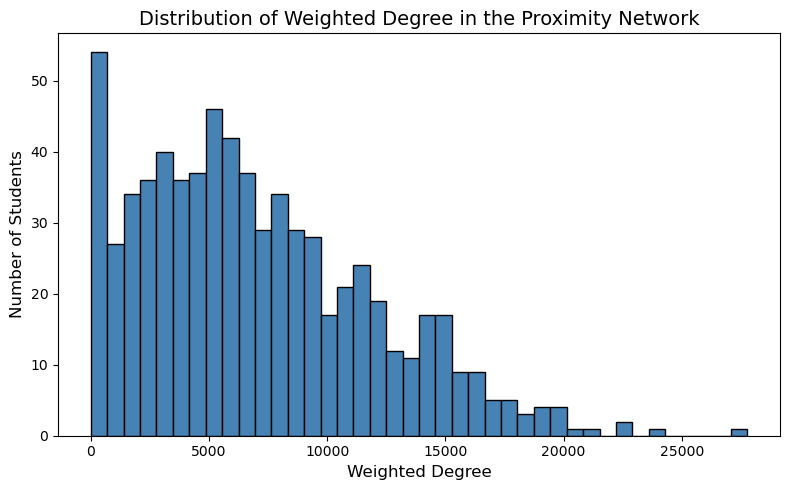

In [14]:
# weighted degree distribution
deg_prox = dict(G_prox.degree(weight="weight"))

plt.figure(figsize=(8,5))
plt.hist(list(deg_prox.values()), bins=40, color="steelblue", edgecolor="black")
plt.xlabel("Weighted Degree", fontsize=12)
plt.ylabel("Number of Students", fontsize=12)
plt.title("Distribution of Weighted Degree in the Proximity Network", fontsize=14)
plt.tight_layout()
plt.show()

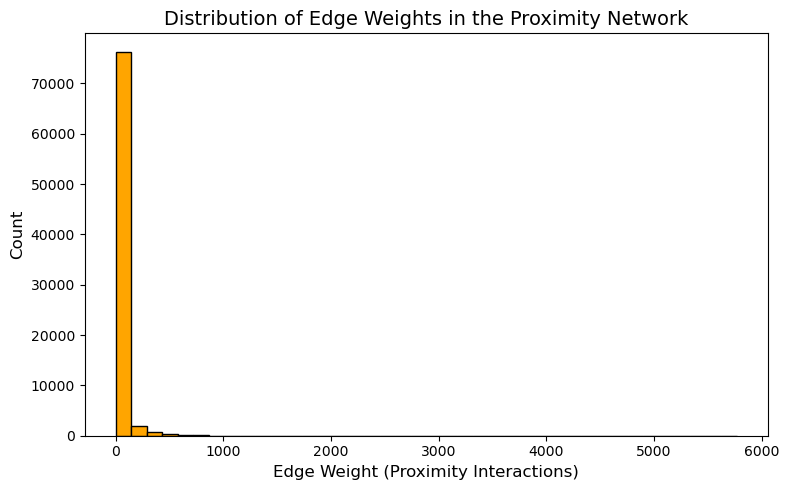

In [15]:
weights = [data['weight'] for _,_,data in G_prox.edges(data=True)]

plt.figure(figsize=(8,5))
plt.hist(weights, bins=40, color="orange", edgecolor="black")
plt.xlabel("Edge Weight (Proximity Interactions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Edge Weights in the Proximity Network", fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import pearsonr, spearmanr

common_users = set(G_prox.nodes()).intersection(G_sms.nodes())

deg_prox_common = [deg_prox[u] for u in common_users]
deg_sms = dict(G_sms.degree(weight="weight"))
deg_sms_common = [deg_sms[u] for u in common_users]

pearson = pearsonr(deg_prox_common, deg_sms_common)
spearman = spearmanr(deg_prox_common, deg_sms_common)

print("Pearson correlation:", pearson)
print("Spearman correlation:", spearman)

Pearson correlation: PearsonRResult(statistic=0.139784843788928, pvalue=0.0013085925750193328)
Spearman correlation: SignificanceResult(statistic=0.28070662882127606, pvalue=5.569840597588176e-11)


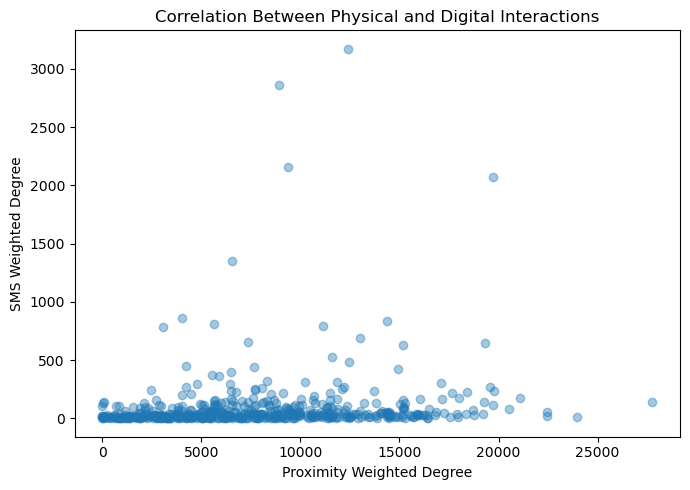

In [17]:
plt.figure(figsize=(7,5))
plt.scatter(deg_prox_common, deg_sms_common, alpha=0.4)
plt.xlabel("Proximity Weighted Degree")
plt.ylabel("SMS Weighted Degree")
plt.title("Correlation Between Physical and Digital Interactions")
plt.tight_layout()
plt.show()

## Advanced Methods

## Communiti-level observation
For **community-level observation**, I'll do a proximity graph becasue it is the densest and most meaningful for physical/social grouping.
NetworkX includes the greedy modularity communities, which groups nodes to maximize modularity, a measure of community structure, and works well with weighted edges.

In [18]:
from networkx.algorithms import community

communities = community.greedy_modularity_communities(G_prox)
community_sizes = []
for c in communities:
    community_sizes.append(len(c))
community_sizes # [353, 334, 3, 2]
sizes_sorted = sorted(community_sizes, reverse=True)
largest_pct = max(sizes_sorted) / G_prox.number_of_nodes() * 100
print("The network splits into", len(communities), "communities")
print("Largest community contains:", largest_pct, "% of students")

The network splits into 4 communities
Largest community contains: 51.01156069364162 % of students


The network splits into 4 communities, but the structure of the network indicates that there are two very dominant communities.

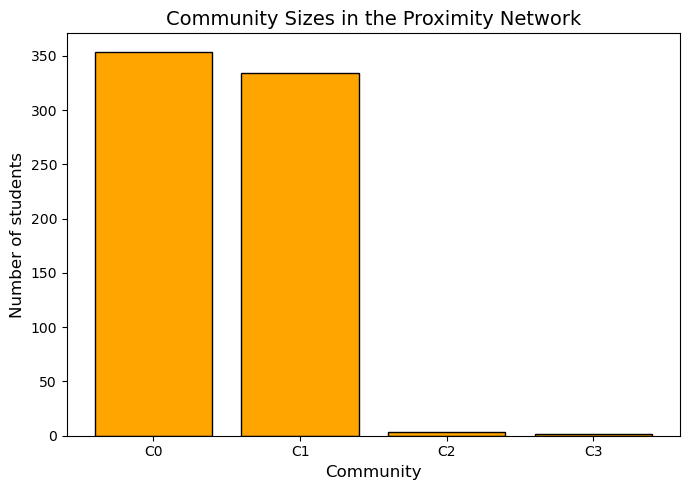

In [19]:
sizes = sorted(community_sizes, reverse=True)
plt.figure(figsize=(7,5))
plt.bar(range(len(sizes)), sizes, color="orange", edgecolor="black")
tick_positions = []
tick_labels = []
for i in range(len(sizes)):
    position = i
    label = f"C{i}" # C(0-4)format
    tick_positions.append(position)
    tick_labels.append(label)
plt.xticks(tick_positions, tick_labels)
plt.xlabel("Community", fontsize=12)
plt.ylabel("Number of students", fontsize=12)
plt.title("Community Sizes in the Proximity Network", fontsize=14)
plt.tight_layout()
plt.show()

Community sizes detected in the proximity network using greedy modularity optimization. The network divides into two large communities (353 and 334 students), which together contain 99% of all nodes, and two very small peripheral communities of size 3 and 2.

## One-subject observation
Then, for **one-subject observation**  I'll do some centrality measurements. Centrality measures the importance of each node (student) in the network. Different centrality metrics capture different interpretations of *importance*.
Weighted centrality measures how many interactions a student has in total. Betweenness centrality measures how often a student lies on shortest paths between other students.

In [20]:
# Weighted centrality
deg_prox = dict(G_prox.degree(weight="weight")) # weighted degree 
top_deg = sorted(deg_prox.items(), key=lambda x: x[1], reverse=True)[:10]
highest = top_deg[0]
print(f"The student the most socially active physically is student number {highest[0]}.")

The student the most socially active physically is student number 100.


Weighted degree represents the total number of Bluetooth proximity interactions per student. The distribution is strongly right-skewed, indicating that most students have relatively few interactions, while a small subset exhibits extremely high levels of social contact.

In [21]:
# Betweenness centrality
bet_prox = nx.betweenness_centrality(G_prox, weight="weight") # betweness centrality
top_bet = sorted(bet_prox.items(), key=lambda x: x[1], reverse=True)[:10]
highest_bet = top_bet[0]
print(f"The student who is the most structurally important connector is student number {highest_bet[0]}.")

The student who is the most structurally important connector is student number 414.


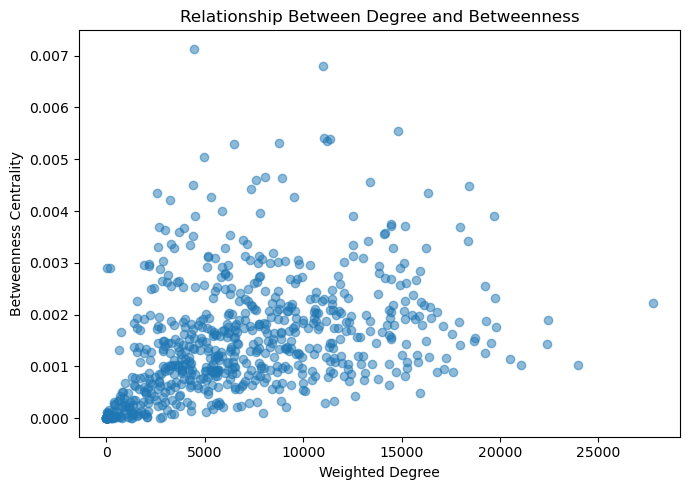

In [22]:
plt.figure(figsize=(7,5))
plt.scatter(list(deg_prox.values()), list(bet_prox.values()), alpha=0.5)
plt.xlabel("Weighted Degree")
plt.ylabel("Betweenness Centrality")
plt.title("Relationship Between Degree and Betweenness")
plt.tight_layout()
plt.show()

Relationship between weighted degree and betweenness centrality for all students in the proximity network. The scatterplot shows no strong linear relationship, indicating that socially active students (high degree) are not necessarily structural bridges between groups (high betweenness).

## More analysis methods

The clustering coefficient measures how likely it is that two neighbors of a given node are also connected to each other. In social terms, it quantifies the presence of triangles small tightly connected groups.

In [23]:
# clustering coefficient
clust_coeff = nx.clustering(G_prox, weight='weight')
avg_clust = sum(clust_coeff.values()) / len(clust_coeff)
avg_clust

0.0013288203305266916

Extremely low, so physical interactions do not usually involve groups of three students.

Connected components is a part of the network where every node is reachable from every other node. The proximity network only has 1 connected component. This means that every student is connected through chains of proximity events.

In [24]:
# connected components
num_components = nx.number_connected_components(G_prox)
num_components

1

In [25]:
com_sms = nx.number_connected_components(G_sms)
com_call = nx.number_connected_components(G_calls)
print(com_sms)
print(com_call)

46
54


Calls and sms form fragmented networks with many isolated groups.

This contrast reinforces that proximity captures broad ambient exposure across the entire student population, whereas digital communication reflects sparse, selective ties.

In [26]:
# average path length in largest connected component
largest_cc = max(nx.connected_components(G_prox), key=len)
G_largest = G_prox.subgraph(largest_cc)
avg_path_length = nx.average_shortest_path_length(G_largest, weight='weight')
avg_path_length

2.083225282952578

The average shortest path length measures how many steps, on average, separate any two students in the largest connected component. Any student is typically only about two edges away from any other student through proximity interactions, which is typical of small-world networks.

## Strength of social ties
To identify the strongest relationships, we sort edges by their weight:

In [27]:
strong_edges = sorted(weights, reverse=True)[:10]
strongest_pairs = sorted(G_prox.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
strongest_pairs

[(322, 321, {'weight': 5766}),
 (557, 419, {'weight': 5428}),
 (59, 575, {'weight': 4770}),
 (300, 301, {'weight': 4074}),
 (449, 47, {'weight': 4061}),
 (286, 62, {'weight': 3957}),
 (553, 343, {'weight': 3876}),
 (476, 240, {'weight': 3799}),
 (208, 422, {'weight': 3655}),
 (91, 90, {'weight': 3637})]

So for example: students 322 and 321 had 5766 interactions.
These represent strong, repeated close-proximity relationships: likely close friends, roommates, partners, or classmates who spend extended time together

In [28]:
strongest_pairs2 = sorted(G_calls.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
strongest_pairs2

[(578, 289, {'weight': 129}),
 (20, 21, {'weight': 82}),
 (90, 91, {'weight': 63}),
 (47, 449, {'weight': 55}),
 (301, 300, {'weight': 53}),
 (48, 49, {'weight': 50}),
 (651, 623, {'weight': 47}),
 (39, 622, {'weight': 44}),
 (470, 678, {'weight': 41}),
 (278, 335, {'weight': 39})]

In [29]:
strongest_pairs1 = sorted(G_sms.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
strongest_pairs1

[(279, 617, {'weight': 2860}),
 (176, 578, {'weight': 1763}),
 (481, 296, {'weight': 863}),
 (20, 21, {'weight': 788}),
 (90, 91, {'weight': 767}),
 (137, 136, {'weight': 597}),
 (274, 632, {'weight': 475}),
 (93, 481, {'weight': 448}),
 (512, 299, {'weight': 378}),
 (218, 382, {'weight': 352})]

Pair (20, 21) appears in calls and SMS, Pair (90, 91) appears in calls and SMS, Pair (300, 301) appears in proximity and calls

## Ego network of student # 100

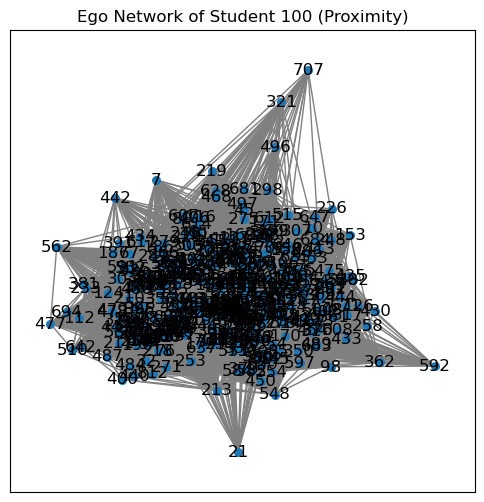

In [30]:
center = 100
ego_nodes = nx.ego_graph(G_prox, center, radius=1)  # neighbors of 100
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(ego_nodes, seed=42)
nx.draw_networkx(ego_nodes, pos=pos, node_size=30, edge_color="gray", with_labels=True)
plt.title("Ego Network of Student 100 (Proximity)")
plt.show()

## Analysis of activity of social interactions by hour
I'll graph each interaction layer by hour, in order to analyze the hours in which each interaction is more present

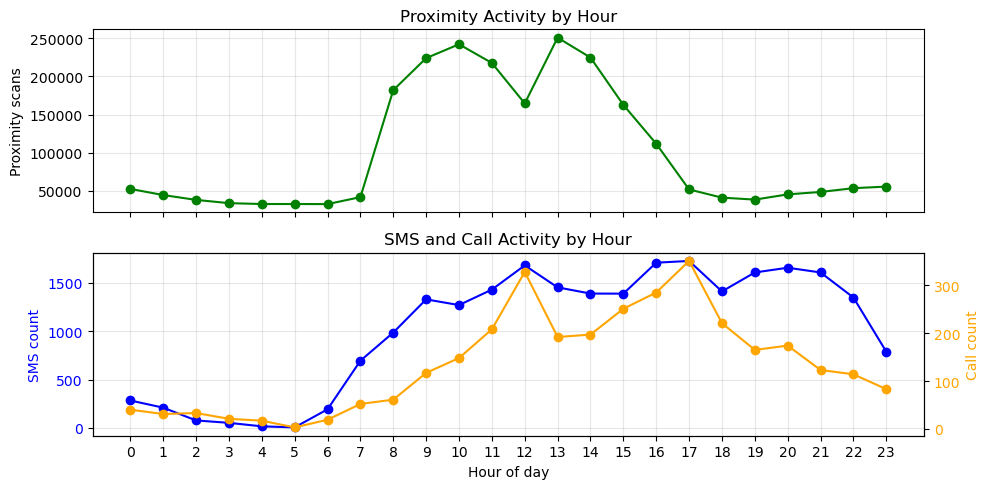

In [42]:
sms['hour'] = pd.to_datetime(sms['timestamp'], unit='s').dt.hour
sms_hours = sms['hour'].value_counts().sort_index()

calls['hour'] = pd.to_datetime(calls['timestamp'], unit='s').dt.hour
call_hours = calls['hour'].value_counts().sort_index()

bt['hour'] = pd.to_datetime(bt['timestamp'], unit='s').dt.hour
prox_hours = bt['hour'].value_counts().sort_index()

fig, axs = plt.subplots(2,1,figsize=(10,5), sharex = True)

axs[0].plot(prox_hours.index, prox_hours.values, marker='o', color='green')
axs[0].set_ylabel("Proximity scans")
axs[0].set_title("Proximity Activity by Hour")
axs[0].grid(alpha=0.3)

ax1 = axs[1]
ax1.plot(sms_hours.index, sms_hours.values, marker='o', color='blue', label="SMS")
ax1.set_ylabel("SMS count", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(call_hours.index, call_hours.values, marker='o', color='orange', label="Calls")
ax2.set_ylabel("Call count", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

axs[1].set_xlabel("Hour of day")
axs[1].set_title("SMS and Call Activity by Hour")
axs[1].grid(alpha=0.3)

plt.xticks(range(24))
plt.tight_layout()
plt.show()

## More analysis methods for relevant insights
Here I compare FB friendships with real-world proximity

In [39]:
fb_pairs = set(tuple(sorted(e)) for e in G_fb.edges())
prox_pairs = set(tuple(sorted(e)) for e in G_prox.edges())
x = len(fb_pairs & prox_pairs) / len(fb_pairs)
print(f"About {x*100:.1f}% of all FB pairs were observed in real physical proximity during the study.")

About 48.7% of all FB pairs were observed in real physical proximity during the study.


In [40]:
from sklearn.linear_model import LinearRegression
X = np.array(deg_prox_common).reshape(-1,1)
y = np.array(deg_sms_common)
model = LinearRegression().fit(X, y)
model.score(X, y)

0.019539802553095065

I also did a simple linear regression model where the input is the proximity weight degree and the label is the SMS weight degree to show how much of the variance in SMS activity can be explained by proximity activity.

The value is about 0.02, meaning that only about 2% of the variability in SMS degree is explained by proximity degree. This means that knowing how socially active someone is in physical space is almost useless for predicting how active they are over SMS.

In [41]:
common_edges = set(G_prox.edges()).intersection(set(G_fb.edges()))
print(f"There are {len(common_edges)} students who are both, connected on FB and observed in physicial proximity")


There are 1483 students who are both, connected on FB and observed in physicial proximity
